In [142]:
import numpy as np
from couchbase.cluster import Cluster
from couchbase.cluster import PasswordAuthenticator
from couchbase import FMT_BYTES
from lxml import html  
import requests
from time import sleep
import json
import argparse
from collections import OrderedDict
from time import sleep
import csv
import couchbase.subdocument as SD
from couchbase.exceptions import NotFoundError

def on_ok(result):
    print("Operation succeeded")
    if hasattr(result, 'value'):
        print ("Value is", result.value)

def on_err(err):
    print("Operation failed", err)
    

cluster = Cluster('couchbase://localhost')
authenticator = PasswordAuthenticator('Frank', 'frank123')
cluster.authenticate(authenticator)
bucket_stocks = cluster.open_bucket('stocks')

In [47]:
tickers = [i.strip().split(';')[-3].strip() for i in open("./SESprice.dat").readlines()]

In [122]:
class Projection:
    
    def __init__(self,nav,eps,eps_bias,eps_scale,irr,g,lifespan):
        self.nav = nav
        self.eps = eps
        self.eps_bias = eps_bias
        self.eps_scale = eps_scale
        self.irr =irr
        self.g = g
        self.lifespan = lifespan
        self.simulate()
        
    def simulate(self,eps_add=0.00,eps_bias_add=0.00):
        nav_proj = [self.nav]
        returns = [self.eps+abs(self.eps)*eps_add]
        
        for _ in range(self.lifespan):
            r_diff = np.random.normal(self.eps_bias+abs(self.eps_bias)*eps_bias_add,self.eps_scale)
            returns.append(returns[-1]+r_diff)
        
        self.returns = returns[1:]
        
        for i in range(self.lifespan):
            new_nav = nav_proj[-1]+self.returns[i]
            nav_proj.append(new_nav)
            
        self.nav_proj = nav_proj[1:]
        
    def set_eps_bias(self,eps_bias):
        self.eps_bias = eps_bias
        
    def npv(self,irr_add=0.00,nav_add=0.00):
        irr = max(1,self.irr*(1+irr_add))
        npv = self.nav+abs(self.nav)*nav_add
        npv += sum([(r-max(0,self.nav_proj[year]*irr)/100.0)/(1+irr/100.0)**(year+1) for year,r in enumerate(self.returns)])
        npv += (self.returns[-1]-max(0,self.returns[-1]*irr/100.00))/(irr-self.g)/(1+irr/100.0)**self.lifespan
        if npv<0:
            return 0
        else:
            return npv
        
    def npv_sim(self,eps_add=0.00,eps_bias_add=0.00,irr_add=0.00,nav_add=0.00):
        self.simulate(eps_add,eps_bias_add)
        return self.npv(irr_add,nav_add)
    
    def to_dict(self):
        return {'nav':self.nav,'eps':self.eps,'eps_bias':self.eps_bias,'eps_scale':self.eps_scale,
        'irr':self.irr,'g':self.g ,'lifespan':self.lifespan}
    
    def from_dict(d):
        return Projection(nav=d['nav'],eps=d['eps'],eps_bias=d['eps_bias'],eps_scale=d['eps_scale'],
                         irr=d['irr'],g=d['g'],lifespan=d['lifespan'])
        

In [104]:
p =  Projection(nav=1,eps=0,eps_bias=0.2,eps_scale=0.2,irr=7,g=1,lifespan=2)
p.set_eps_bias(0.5)
#p.npv_sim()
print(p.npv()) 
d=p.to_dict()
Projection.from_dict(d).npv()

1.3159855469381752


2.5899254726294756

In [246]:
class Stock:

    def __init__(self,ticker, price, nav, eps):
        self.ticker = ticker
        self.price = price
        self.nav = nav
        self.eps = eps

    def initialize(self):
        self.matched_projections = []
        self.refresh_price()
        
    def set_projections(self,projections):
        self.matched_projections = projections
        
    def random_projection(self):
        return Projection(nav=np.random.normal(self.nav,self.price/10),
              eps=np.random.normal(self.eps,abs(self.eps)+self.price/10),
              eps_bias=np.random.normal(0,abs(self.eps)+self.price),
              eps_scale=abs(np.random.normal(0,abs(self.eps)+self.price)),
              irr=abs(np.random.normal(15,10)),
              g=np.random.normal(5,15),
              lifespan=np.random.geometric(0.1))
        
    def match_price(self,limit=10000):
        n= len(self.matched_projections)
        while(limit>0):
            p = self.random_projection()
            if abs((p.npv()/self.price)-1)<0.2:
                self.matched_projections.append(p.to_dict())
            limit -=1
            
        print("{} new projections matched".format(len(self.matched_projections)-n))
            
    def refresh_price(self,match_price=True):
        if match_price:
            self.match_price()
        self.price_estimates = [Projection.from_dict(p).npv() for p in self.matched_projections]
    
    def intrinsic_value(self):
        return np.median(self.price_estimates)
    
    def price_volitility(self):
        return np.std(self.price_estimates)
    
    def implied_eps(self):
        return np.mean([p['eps'] for p in self.matched_projections])
    
    def implied_eps_bias(self):
        return np.mean([p['eps_bias'] for p in self.matched_projections])
    
    def implied_irr(self):
        return np.mean([p['irr'] for p in self.matched_projections])
    
    def implied_g(self):
        return np.mean([p['g'] for p in self.matched_projections])
    
    def implied_lifespan(self):
        return np.mean([p['lifespan'] for p in self.matched_projections])
    
    def implied_nav(self):
        return np.mean([p['nav'] for p in self.matched_projections])
    
    def eps_elasticity_up(self,magnitude=0.2):
        price_up = np.median([Projection.from_dict(p).npv_sim(eps_add=magnitude) for p in self.matched_projections])
        return (price_up/self.intrinsic_value()-1)/magnitude
    
    def eps_elasticity_down(self,magnitude=0.2):
        price_down = np.median([Projection.from_dict(p).npv_sim(eps_add=-magnitude) for p in self.matched_projections])
        return (self.intrinsic_value()/price_down-1)/magnitude
    
    def eps_bias_elasticity_up(self,magnitude=0.2):
        price_up = np.median([Projection.from_dict(p).npv_sim(eps_bias_add=magnitude) for p in self.matched_projections])
        return (price_up/self.intrinsic_value()-1)/magnitude
    
    def eps_bias_elasticity_down(self,magnitude=0.2):
        price_down = np.median([Projection.from_dict(p).npv_sim(eps_bias_add=-magnitude) for p in self.matched_projections])
        return (self.intrinsic_value()/price_down-1)/magnitude
    
    def irr_elasticity_up(self,magnitude=0.2):
        price_up = np.median([Projection.from_dict(p).npv_sim(irr_add=-magnitude) for p in self.matched_projections])
        return (price_up/self.intrinsic_value()-1)/magnitude
    
    def irr_elasticity_down(self,magnitude=0.2):
        price_down = np.median([Projection.from_dict(p).npv_sim(irr_add=magnitude) for p in self.matched_projections])
        return (self.intrinsic_value()/price_down-1)/magnitude
    
    def nav_elasticity_up(self,magnitude=0.2):
        price_up = np.median([Projection.from_dict(p).npv_sim(nav_add=magnitude) for p in self.matched_projections])
        return (price_up/self.intrinsic_value()-1)/magnitude
    
    def nav_elasticity_down(self,magnitude=0.2):
        price_down = np.median([Projection.from_dict(p).npv_sim(nav_add=-magnitude) for p in self.matched_projections])
        return (self.intrinsic_value()/price_down-1)/magnitude
    
    def summary(self):
        print ("""Stock {} with intrinsic value {:.3f} and estimate volitility {:.3f}
implied eps: {:.3f} with upside elasticity: {:.2f} with downside elasticity: {:.2f}
implied eps bias: {:.3f} with upside elasticity: {:.2f} with downside elasticity: {:.2f}
implied irr: {:.1f}% with upside elasticity: {:.2f} with downside elasticity: {:.2f}
implied g: {:.1f}% after year {:.1f}  
implied nav: {:.3f} with upside elasticity: {:.2f} with downside elasticity: {:.2f}
        
        """.format(self.ticker,self.intrinsic_value(),self.price_volitility(),
                   self.implied_eps(),self.eps_elasticity_up(),self.eps_elasticity_down(),
                   self.implied_eps_bias(),self.eps_bias_elasticity_up(),self.eps_bias_elasticity_down(),
                   self.implied_irr(),self.irr_elasticity_up(),self.irr_elasticity_down(),
                   self.implied_g(),self.implied_lifespan(),
                   self.implied_nav(),self.nav_elasticity_up(),self.nav_elasticity_down(),
                  ))
        
    def save_projections(self,bucket):
        try:
            bucket.mutate_in(self.ticker, SD.upsert('matched_projections', self.matched_projections))
        except NotFoundError as e:
            print ("Item not found", e)
            
    def append_projections(self,bucket):
        try:
            bucket.mutate_in(self.ticker, SD.array_append('matched_projections', *self.matched_projections))
        except NotFoundError as e:
            print ("Item not found", e)
        

In [247]:
x = Stock("RE4.SI",0.079,0.1281,-0.03639)
x.initialize()
x.summary()
#x.save_projections(bucket_stocks)
x.append_projections(bucket_stocks)


265 new projections matched
Stock RE4.SI with intrinsic value 0.072 and estimate volitility 0.148
implied eps: -0.035 with upside elasticity: 0.91 with downside elasticity: 0.02
implied eps bias: 0.020 with upside elasticity: 1.20 with downside elasticity: 0.49
implied irr: 18.8% with upside elasticity: 1.31 with downside elasticity: 0.51
implied g: 6.7% after year 4.6  
implied nav: 0.128 with upside elasticity: 2.07 with downside elasticity: 2.14
        
        


In [414]:
x.refresh_price()
#x.set_eps_bias(eps_bias=-0.05)
x.summary()

259 new projections matched
Stock GeoEnergy with intrinsic value 0.016 and estimate volitility 0.153
implied eps: -0.034
implied eps bias: -0.027 with elasticity: 0.00
implied irr: 18.7% with elasticity: -0.00 
implied g: 5.5% after year 4.6  
implied nav: 0.128 with elasticity: 0.02
        
        


In [144]:
x.refresh_price()
x.summary()

138 new projections matched
Stock GeoEnergy with intrinsic value 0.073 and estimate volitility 0.381
implied default rate: 32% with elasticity: 0.01
implied eps: -0.041
implied eps bias: 0.020 with elasticity: 0.01
implied eps skew: 0.015
implied irr: 27.4% with elasticity: -0.00 
implied nav: 0.128 with elasticity: -0.01
        
        


In [430]:
y = Stock("UD2","Japfa",0.48,0.6306,0.07971)
y.summary()
y.save(bucket_stocks)

337 new projections matched
Stock Japfa with intrinsic value 0.472 and estimate volitility 0.751
implied eps: 0.078
implied eps bias: 0.025 with elasticity: -0.03
implied irr: 18.7% with elasticity: -0.07 
implied g: 5.0% after year 5.0  
implied nav: 0.627 with elasticity: 0.10
        
        


In [250]:
y.refresh_price(match_price=False)
y.summary()

Stock Japfa with intrinsic value 0.501 and estimate volitility 1.137
implied default rate: 33% with elasticity: 0.04
implied eps: 0.093
implied eps bias: 0.073 with elasticity: 0.01
implied eps skew: 0.032
implied irr: 23.1% with elasticity: -0.10 
implied nav: 0.631 with elasticity: -0.01
        
        


In [415]:
z= Stock("DO",1.8,23.47,-2.59)
z.summary()

85 new projections matched
Stock DO with intrinsic value 1.409 and estimate volitility 8.236
implied eps: -2.868
implied eps bias: -0.054 with elasticity: -0.18
implied irr: 20.8% with elasticity: -1.81 
implied g: 3.7% after year 11.7  
implied nav: 23.462 with elasticity: 3.68
        
        


In [425]:
z= Stock("TXMD",1,0.04,-0.71)
#z.refresh_price()
z.summary()

223 new projections matched
Stock TXMD with intrinsic value 0.905 and estimate volitility 2.251
implied eps: -0.641
implied eps bias: 0.797 with elasticity: 0.10
implied irr: 18.6% with elasticity: -0.51 
implied g: 6.0% after year 4.8  
implied nav: 0.047 with elasticity: 0.01
        
        


In [1741]:
y= Stock("SURF",1.78,2.03,-1.97)

In [1614]:
x.match_price(10000)
len(x.matched_projections)

1093

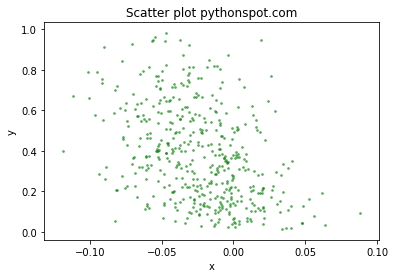

In [960]:
import matplotlib.pyplot as plt
a = [p.eps_bias for p in x.matched_projections ]
b = [p.default_rate for p in x.matched_projections]

area = np.pi

plt.scatter(a, b, s=area, c='g', alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [961]:
np.corrcoef(a,b)

array([[ 1.        , -0.39892864],
       [-0.39892864,  1.        ]])

In [ ]:
for row in bucket_stocks.n1ql_query("""
    SELECT * FROM stocks 
    where quote_currency==financial_currency  
        and quote is not null 
        and matched_projections is not missing
        """):
    stock = row['stocks']
    ticker = stock['ticker']
    quote = float(stock['quote'])
    eps = float(stock['eps'])
    book_value=float(stock['book_value'])
    
    s = Stock(ticker,quote,book_value,eps)
    s.initialize()
    s.append_projections(bucket_stocks)
    #if s.implied_eps_bias() < -0.01 and s.implied_eps() >0.02 :
     #   print (s.summary())

368 new projections matched
73 new projections matched
386 new projections matched
349 new projections matched
250 new projections matched
108 new projections matched
128 new projections matched
364 new projections matched
365 new projections matched
88 new projections matched
360 new projections matched
400 new projections matched
392 new projections matched
406 new projections matched
242 new projections matched
373 new projections matched
321 new projections matched
268 new projections matched
361 new projections matched
390 new projections matched
415 new projections matched
322 new projections matched
235 new projections matched
356 new projections matched
191 new projections matched
282 new projections matched
436 new projections matched
167 new projections matched
356 new projections matched
294 new projections matched
166 new projections matched
309 new projections matched
377 new projections matched
272 new projections matched
372 new projections matched
321 new projections ma

In [241]:
for row in bucket_stocks.n1ql_query("""
    SELECT * FROM stocks 
    where quote_currency==financial_currency  
        and matched_projections is not missing 
        """):
    stock = row['stocks']
    ticker = stock['ticker']
    quote = float(stock['quote'])
    eps = float(stock['eps'])
    book_value=float(stock['book_value'])
    projections = stock['matched_projections']
    s = Stock(ticker,quote,book_value,eps)
    s.set_projections(projections)
    s.refresh_price(False)
    if s.implied_eps()*s.implied_eps_bias()>0.0001 and\
        s.eps_elasticity_down()<1 and \
        s.eps_bias_elasticity_down()<1 and \
        s.irr_elasticity_down()<1 and \
        s.nav_elasticity_down()<1:
        print (s.summary())

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars


Stock ME8U.SI with intrinsic value 2.276 and estimate volitility 6.009
implied eps: 0.157 with upside elasticity: -0.03 with downside elasticity: 0.09
implied eps bias: 0.867 with upside elasticity: 0.78 with downside elasticity: 0.92
implied irr: 18.4% with upside elasticity: 1.18 with downside elasticity: 1.60
implied g: 4.7% after year 5.1  
implied nav: 1.581 with upside elasticity: 0.44 with downside elasticity: 1.00
        
        
None
Stock N2IU.SI with intrinsic value 1.824 and estimate volitility 2.664
implied eps: 0.353 with upside elasticity: 0.31 with downside elasticity: -0.09
implied eps bias: 0.251 with upside elasticity: 0.96 with downside elasticity: 0.29
implied irr: 18.1% with upside elasticity: 0.54 with downside elasticity: 1.21
implied g: 4.8% after year 4.3  
implied nav: 1.735 with upside elasticity: 1.54 with downside elasticity: 0.61
        
        
None
Stock S58.SI with intrinsic value 2.834 and estimate volitility 4.417
implied eps: 0.168 with upside e